The code below establishes a linear relation between $-log(\tilde{t})$ and $n$ (i.e. the number of times the photon orbits the blackhole)

## 1. Slower Version

[1.00000000e-07 3.16227766e-08 1.00000000e-08 3.16227766e-09
 1.00000000e-09 3.16227766e-10]
t_tilde = 1.0e-07 -> revolutions ≈ 3.2375712326605393
t_tilde = 3.2e-08 -> revolutions ≈ 3.4208063186422386
t_tilde = 1.0e-08 -> revolutions ≈ 3.604049362371092
t_tilde = 3.2e-09 -> revolutions ≈ 3.7873608427254752
t_tilde = 1.0e-09 -> revolutions ≈ 3.971391703422634
t_tilde = 3.2e-10 -> revolutions ≈ 4.163286409857963


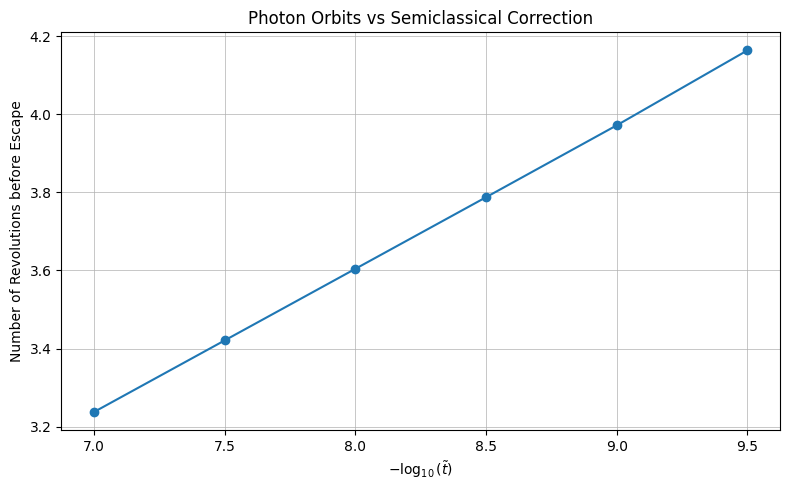

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

# --- Physical Constants in SI units ---
G = 6.67430e-11         # m^3 kg^-1 s^-2
c = 2.99792458e8        # m/s
M_sun = 1.989e30        # kg

# Schwarzschild radius
r_s = 2 * G * M_sun / c**2
r_s2_inv = 1 / r_s**2

# --- Mathematical functions ---
@njit
def coth(z):
    return 1.0 / np.tanh(z)

@njit
def htt(x):
    inv_x2 = 1.0 / (x * x)
    return -2 * x**3 * (x**2 - coth(inv_x2))

@njit
def hrr(x):
    inv_x2 = 1.0 / (x * x)
    denom = (1 - x)**2
    return -2 * x**2 / denom * (x**2 - coth(inv_x2))

@njit
def hphiphi(x):
    return -2 * r_s**2 / x * (x - coth(1.0 / x))

@njit
def g0(x, zeta_sq):
    return x**3 - x**2 + zeta_sq

@njit
def dg0(x):
    return 3 * x**2 - 2 * x

@njit
def h(x, zeta_sq):
    g = g0(x, zeta_sq)
    h_rr = hrr(x)
    h_pp = hphiphi(x)
    h_tt = htt(x)

    term1 = g * ((1 - x) * h_rr - x**2 * r_s2_inv * h_pp)
    term2 = -zeta_sq * (x**2 * r_s2_inv * h_pp - h_tt / (1 - x))
    return term1 + term2

@njit
def dh(x, zeta_sq):
    dx = 1e-10
    return (h(x + dx, zeta_sq) - h(x - dx, zeta_sq)) / (2 * dx)

# --- ODE System and RK4 ---
@njit
def deriv(y, t_tilde, zeta_sq):
    x, v = y
    return np.array([v, 0.5 * (dg0(x) + t_tilde * dh(x, zeta_sq))])

@njit
def rk4_step(y, h_phi, t_tilde, zeta_sq):
    k1 = h_phi * deriv(y, t_tilde, zeta_sq)
    k2 = h_phi * deriv(y + 0.5 * k1, t_tilde, zeta_sq)
    k3 = h_phi * deriv(y + 0.5 * k2, t_tilde, zeta_sq)
    k4 = h_phi * deriv(y + k3, t_tilde, zeta_sq)
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.0

@njit
def integrate_rk4(y_ini, phis, h_phi, t_tilde, zeta_sq):
    N = len(phis)
    ys = np.empty((N, 2))
    y = y_ini.copy()
    for i in range(N):
        ys[i] = y
        y = rk4_step(y, h_phi, t_tilde, zeta_sq)
    return ys

# --- Main loop over t_tilde values ---
# t_tilde_values = np.array([1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13])
exponents = np.arange(7,10,0.5)
t_tilde_values = 1/10**exponents
print(t_tilde_values)
revolutions_list = []

# Integration setup
n_revolutions = 6      # simulate up to this many revolutions
h_phi = 1e-5
phis = np.arange(0, 2 * np.pi * n_revolutions, h_phi)
threshold = 100 * r_s

for t_tilde in t_tilde_values:
    # Critical distances depend on t_tilde
    P_c = 1.5 * r_s * (1 + (2.03 / 3) * t_tilde)
    b_c = (3 * np.sqrt(3) / 2) * r_s * (1 + 0.8066 * t_tilde)
    zeta_sq = (r_s / b_c)**2

    # Initial conditions
    x0 = r_s / P_c
    v0 = 0.0
    y_ini = np.array([x0, v0])

    # Integrate
    ys = integrate_rk4(y_ini, phis, h_phi, t_tilde, zeta_sq)
    xs = ys[:, 0]
    r_vals = r_s / xs

    # Find escape index
    idx_escape = np.argmax(r_vals > threshold)
    if r_vals[idx_escape] > threshold:
        phi_escape = phis[idx_escape]
        revolutions_escape = phi_escape / (2 * np.pi)
    else:
        revolutions_escape = np.nan  # didn't escape within simulated revolutions

    revolutions_list.append(revolutions_escape)
    print(f"t_tilde = {t_tilde:.1e} -> revolutions ≈ {revolutions_escape}")

# --- Plotting results ---
plt.figure(figsize=(8, 5))
plt.plot(-np.log10(t_tilde_values), revolutions_list, 'o-', linewidth=1.5, markersize=6)
plt.xlabel(r"$-\log_{10}(\tilde{t})$")
plt.ylabel("Number of Revolutions before Escape")
plt.title("Photon Orbits vs Semiclassical Correction")
plt.grid(True, linewidth=0.5)
plt.tight_layout()
plt.show()


Array of t_tilde values :

[1.00000000e-05 3.16227766e-06 1.00000000e-06 3.16227766e-07
 1.00000000e-07 3.16227766e-08 1.00000000e-08 3.16227766e-09
 1.00000000e-09 3.16227766e-10 1.00000000e-10 3.16227766e-11
 1.00000000e-11 3.16227766e-12 1.00000000e-12 3.16227766e-13]

Simulation Results :

t_tilde = 1.0e-05 -> revolutions ≈ 2.5
t_tilde = 3.2e-06 -> revolutions ≈ 2.69
t_tilde = 1.0e-06 -> revolutions ≈ 2.87
t_tilde = 3.2e-07 -> revolutions ≈ 3.05
t_tilde = 1.0e-07 -> revolutions ≈ 3.24
t_tilde = 3.2e-08 -> revolutions ≈ 3.42
t_tilde = 1.0e-08 -> revolutions ≈ 3.6
t_tilde = 3.2e-09 -> revolutions ≈ 3.79
t_tilde = 1.0e-09 -> revolutions ≈ 3.97
t_tilde = 3.2e-10 -> revolutions ≈ 4.16
t_tilde = 1.0e-10 -> revolutions ≈ 4.43
t_tilde = 3.2e-11 -> revolutions ≈ 5.08
t_tilde = 1.0e-11 -> revolutions ≈ 7.07
t_tilde = 3.2e-12 -> revolutions ≈ 13.3
t_tilde = 1.0e-12 -> revolutions ≈ 33.2
t_tilde = 3.2e-13 -> revolutions ≈ 95.5


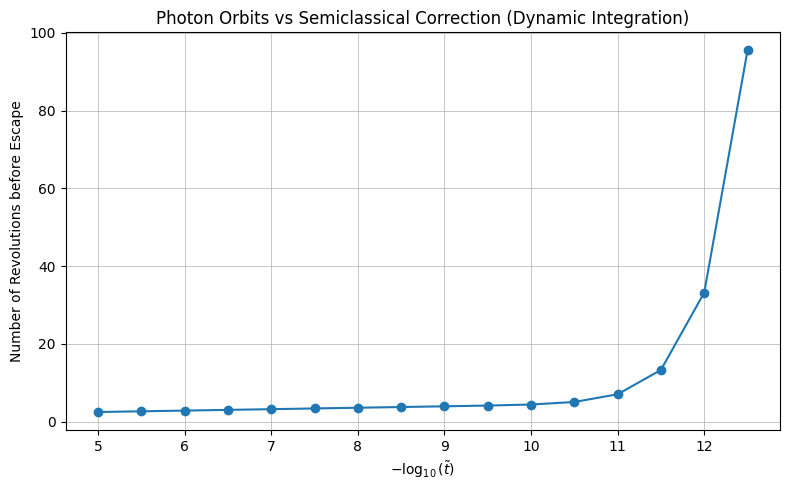

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

# --- Physical Constants in SI units ---
G = 6.67430e-11         # m^3 kg^-1 s^-2
c = 2.99792458e8        # m/s
M_sun = 1.989e30        # kg

# Schwarzschild radius
r_s = 2 * G * M_sun / c**2
r_s2_inv = 1 / r_s**2


# --- Mathematical functions ---

epsilon = 1e-15
@njit
def safe_val(x, eps=epsilon):
    # Prevent division by zero and singularities
    if x < eps:     # effectively r → ∞
        return eps
    if abs(1 - x) < eps:  # avoid (1-x)^2 blowup
        return 1 - eps
    return x


@njit
def coth(z):
    return 1.0 / np.tanh(z)

@njit
def htt(x):
    x = safe_val(x)
    inv_x2 = 1.0 / (x * x)
    return -2 * x**3 * (x**2 - coth(inv_x2))

@njit
def hrr(x):
    x = safe_val(x)
    inv_x2 = 1.0 / (x * x)
    denom = (1 - x)**2
    return -2 * x**2 / denom * (x**2 - coth(inv_x2))

@njit
def hphiphi(x):
    x = safe_val(x)
    return -2 * r_s**2 / x * (x - coth(1.0 / x))


@njit
def g0(x, zeta_sq):
    return x**3 - x**2 + zeta_sq

@njit
def dg0(x):
    return 3 * x**2 - 2 * x

@njit
def h(x, zeta_sq):
    g = g0(x, zeta_sq)
    h_rr = hrr(x)
    h_pp = hphiphi(x)
    h_tt = htt(x)

    term1 = g * ((1 - x) * h_rr - x**2 * r_s2_inv * h_pp)
    term2 = -zeta_sq * (x**2 * r_s2_inv * h_pp - h_tt / (1 - x))
    return term1 + term2

@njit
def dh(x, zeta_sq):
    dx = 1e-10
    return (h(x + dx, zeta_sq) - h(x - dx, zeta_sq)) / (2 * dx)

# --- ODE System and RK4 ---
@njit
def deriv(y, t_tilde, zeta_sq):
    x, v = y
    return np.array([v, 0.5 * (dg0(x) + t_tilde * dh(x, zeta_sq))])

@njit
def rk4_step(y, h_phi, t_tilde, zeta_sq):
    k1 = h_phi * deriv(y, t_tilde, zeta_sq)
    k2 = h_phi * deriv(y + 0.5 * k1, t_tilde, zeta_sq)
    k3 = h_phi * deriv(y + 0.5 * k2, t_tilde, zeta_sq)
    k4 = h_phi * deriv(y + k3, t_tilde, zeta_sq)
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.0

# --- Dynamic integration until escape ---
def simulate_escape(t_tilde, h_phi=1e-5, max_revolutions=100):
    # Critical distances
    P_c = 1.5 * r_s * (1 + (2.03 / 3) * t_tilde)
    b_c = (3 * np.sqrt(3) / 2) * r_s * (1 + 0.8066 * t_tilde)
    zeta_sq = (r_s / b_c)**2

    # Initial conditions
    x0 = r_s / P_c
    v0 = 0.0
    y = np.array([x0, v0])

    threshold = 100 * r_s
    phi = 0.0

    # Integrate step by step
    for step in range(int(max_revolutions * 2*np.pi / h_phi)):
        y = rk4_step(y, h_phi, t_tilde, zeta_sq)
        phi += h_phi
        r_val = r_s / max(y[0], epsilon)
        if r_val > threshold:   # escape condition
            return phi / (2*np.pi)

    return np.nan  # did not escape within max_revolutions

# --- Main loop over t_tilde values ---
exponents = np.arange(5, 13, 0.5)     # example range
t_tilde_values = 1.0/(10.0**exponents)
print(f'Array of t_tilde values :\n\n{t_tilde_values}\n')
revolutions_list = []

print(f"Simulation Results :\n")
for t_tilde in t_tilde_values:
    revolutions_escape = simulate_escape(t_tilde, h_phi=1e-5, max_revolutions=200)
    revolutions_list.append(revolutions_escape)
    print(f"t_tilde = {t_tilde:.1e} -> revolutions ≈ {revolutions_escape:.4}")

# --- Plotting results ---
plt.figure(figsize=(8, 5))
plt.plot(-np.log10(t_tilde_values), revolutions_list, 'o-', linewidth=1.5, markersize=6)
plt.xlabel(r"$-\log_{10}(\tilde{t})$")
plt.ylabel("Number of Revolutions before Escape")
plt.title("Photon Orbits vs Semiclassical Correction (Dynamic Integration)")
plt.grid(True, linewidth=0.5)
plt.tight_layout()
plt.show()


## 2. Faster Version

Array of t_tilde values:
 [1.00000000e-05 3.16227766e-06 1.00000000e-06 3.16227766e-07
 1.00000000e-07 3.16227766e-08 1.00000000e-08 3.16227766e-09
 1.00000000e-09 3.16227766e-10 1.00000000e-10 3.16227766e-11
 1.00000000e-11 3.16227766e-12 1.00000000e-12 3.16227766e-13
 1.00000000e-13 3.16227766e-14 1.00000000e-14 3.16227766e-15] 

Compiling / warming up jitted functions (this may take a few seconds)...
Warm-up done in 19.16 s

Batch run time: 300.350 s

Simulation results:
t_tilde = 1.000e-05 -> revolutions ≈ 2.504
t_tilde = 3.162e-06 -> revolutions ≈ 2.688
t_tilde = 1.000e-06 -> revolutions ≈ 2.871
t_tilde = 3.162e-07 -> revolutions ≈ 3.054
t_tilde = 1.000e-07 -> revolutions ≈ 3.238
t_tilde = 3.162e-08 -> revolutions ≈ 3.421
t_tilde = 1.000e-08 -> revolutions ≈ 3.604
t_tilde = 3.162e-09 -> revolutions ≈ 3.787
t_tilde = 1.000e-09 -> revolutions ≈ 3.971
t_tilde = 3.162e-10 -> revolutions ≈ 4.163
t_tilde = 1.000e-10 -> revolutions ≈ 4.432
t_tilde = 3.162e-11 -> revolutions ≈ 5.084
t_til

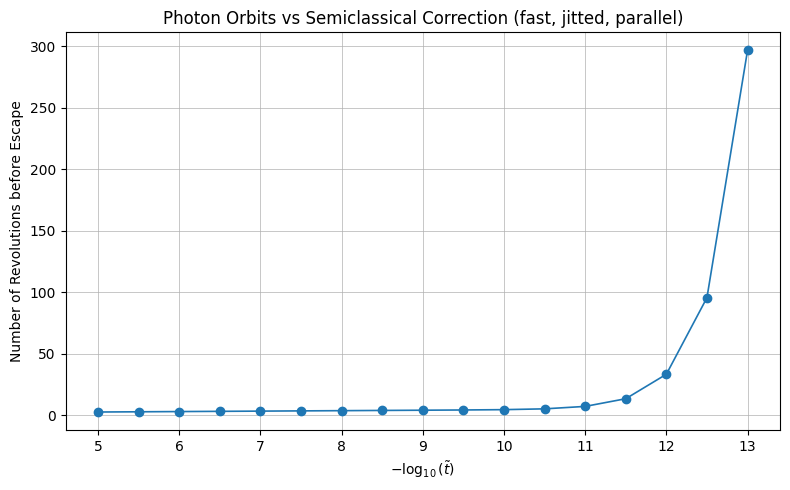

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
import math
import time

# --- Physical Constants in SI units ---
G = 6.67430e-11         # m^3 kg^-1 s^-2
c = 2.99792458e8        # m/s
M_sun = 1.989e30        # kg

# Schwarzschild radius (float)
r_s = 2.0 * G * M_sun / (c**2)
r_s2_inv = 1.0 / (r_s * r_s)

# numerical safety
EPSILON = 1e-15

# --- Mathematical functions (Numba-friendly, using math.*) ---
@njit(inline='always')
def safe_val(x, eps=EPSILON):
    # Prevent division by zero and singularities
    if x < eps:
        return eps
    if abs(1.0 - x) < eps:
        return 1.0 - eps
    return x

@njit(inline='always')
def coth(z):
    # coth(z) = 1/tanh(z)
    return 1.0 / math.tanh(z)

@njit(inline='always')
def htt(x):
    x = safe_val(x)
    inv_x2 = 1.0 / (x * x)
    # -2 * x^3 * (x^2 - coth(inv_x2))
    return -2.0 * x**3 * (x**2 - coth(inv_x2))

@njit(inline='always')
def hrr(x):
    x = safe_val(x)
    inv_x2 = 1.0 / (x * x)
    denom = (1.0 - x) * (1.0 - x)
    # -2 * x^2 / denom * (x^2 - coth(inv_x2))
    return -2.0 * x**2 / denom * (x**2 - coth(inv_x2))

@njit(inline='always')
def hphiphi(x):
    x = safe_val(x)
    # -2 * r_s^2 / x * (x - coth(1.0/x))
    return -2.0 * (r_s * r_s) / x * (x - coth(1.0 / x))

@njit(inline='always')
def g0(x, zeta_sq):
    return x**3 - x**2 + zeta_sq

@njit(inline='always')
def dg0(x):
    return 3.0 * x**2 - 2.0 * x

@njit(inline='always')
def h(x, zeta_sq):
    # compute h(x; zeta_sq)
    # Note: safe_val is applied inside the subfunctions
    g = g0(x, zeta_sq)
    h_rr = hrr(x)
    h_pp = hphiphi(x)
    h_tt = htt(x)

    term1 = g * ((1.0 - x) * h_rr - x**2 * r_s2_inv * h_pp)
    term2 = -zeta_sq * (x**2 * r_s2_inv * h_pp - h_tt / (1.0 - x))
    return term1 + term2

# dh computed by central difference but jitted + inlined
@njit(inline='always')
def dh(x, zeta_sq):
    dx = 1e-9  # slightly larger dx for stability and speed; adjust if needed
    return (h(x + dx, zeta_sq) - h(x - dx, zeta_sq)) / (2.0 * dx)

# --- Scalar RK4 (numba-friendly, no np.array allocations) ---
@njit(inline='always')
def deriv_scalar(x, v, t_tilde, zeta_sq):
    # returns dx/dphi, dv/dphi
    # dx/dphi = v
    # dv/dphi = 0.5 * (dg0(x) + t_tilde * dh(x, zeta_sq))
    return v, 0.5 * (dg0(x) + t_tilde * dh(x, zeta_sq))

@njit(inline='always')
def rk4_step_scalar(x, v, h_phi, t_tilde, zeta_sq):
    dx1, dv1 = deriv_scalar(x, v, t_tilde, zeta_sq)

    x2 = x + 0.5 * h_phi * dx1
    v2 = v + 0.5 * h_phi * dv1
    dx2, dv2 = deriv_scalar(x2, v2, t_tilde, zeta_sq)

    x3 = x + 0.5 * h_phi * dx2
    v3 = v + 0.5 * h_phi * dv2
    dx3, dv3 = deriv_scalar(x3, v3, t_tilde, zeta_sq)

    x4 = x + h_phi * dx3
    v4 = v + h_phi * dv3
    dx4, dv4 = deriv_scalar(x4, v4, t_tilde, zeta_sq)

    x_new = x + (h_phi / 6.0) * (dx1 + 2.0*dx2 + 2.0*dx3 + dx4)
    v_new = v + (h_phi / 6.0) * (dv1 + 2.0*dv2 + 2.0*dv3 + dv4)
    return x_new, v_new

# --- Jitted simulate_escape: entire integration in compiled code ---
@njit
def simulate_escape_jit(t_tilde, h_phi=1e-5, max_revolutions=500):
    # compute zeta_sq from t_tilde
    P_c = 1.5 * r_s * (1.0 + (2.03 / 3.0) * t_tilde)
    b_c = (3.0 * math.sqrt(3.0) / 2.0) * r_s * (1.0 + 0.8066 * t_tilde)
    zeta_sq = (r_s / b_c) ** 2

    # initial conditions
    x = r_s / P_c   # x = r_s / r
    v = 0.0

    threshold = 100.0 * r_s
    phi = 0.0

    max_steps = int(max_revolutions * 2.0 * math.pi / h_phi)
    for step in range(max_steps):
        x, v = rk4_step_scalar(x, v, h_phi, t_tilde, zeta_sq)
        phi += h_phi
        # compute r and check escape; guard against x <= 0
        x_safe = x if x > EPSILON else EPSILON
        r_val = r_s / x_safe
        if r_val > threshold:
            return phi / (2.0 * math.pi)
    return math.nan

# --- Parallel batch runner ---
@njit(parallel=True)
def run_batch_jit(t_tilde_array, h_phi=1e-5, max_revolutions=100):
    n = t_tilde_array.shape[0]
    out = np.empty(n, dtype=np.float64)
    for i in prange(n):
        out[i] = simulate_escape_jit(t_tilde_array[i], h_phi, max_revolutions)
    return out

# ---------------------------
# Main script: prepare t_tilde list, run batch, plot
# ---------------------------
def main():
    # choose exponents and build t_tilde array as float
    exponents = np.arange(5.0, 15.0, 0.5)   # example: 5.0, 5.5, ... 12.5
    t_tilde_values = 1.0 / (10.0 ** exponents)  # guaranteed floats
    print("Array of t_tilde values:\n", t_tilde_values, "\n")

    # parameters
    h_phi = 1e-5
    max_revolutions = 300  # increase if necessary for tiny t_tilde

    # warm-up compile and timing
    print("Compiling / warming up jitted functions (this may take a few seconds)...")
    t0 = time.time()
    # single call to compile
    _ = simulate_escape_jit(t_tilde_values[0], h_phi, 10)
    # compile batch
    _ = run_batch_jit(t_tilde_values, h_phi, 10)
    t1 = time.time()
    print(f"Warm-up done in {t1-t0:.2f} s\n")

    # run batch (parallel)
    tstart = time.time()
    results = run_batch_jit(t_tilde_values, h_phi, max_revolutions)
    tend = time.time()
    print(f"Batch run time: {tend-tstart:.3f} s\n")

    # print results
    print("Simulation results:")
    for tt, rv in zip(t_tilde_values, results):
        print(f"t_tilde = {tt:.3e} -> revolutions ≈ {rv:.4g}")

    # plotting (only positive t_tilde)
    mask = t_tilde_values > 0.0
    x = -np.log10(t_tilde_values[mask])
    y = results[mask]

    plt.figure(figsize=(8, 5))
    plt.plot(x, y, 'o-', linewidth=1.2, markersize=6)
    plt.xlabel(r"$-\log_{10}(\tilde{t})$")
    plt.ylabel("Number of Revolutions before Escape")
    plt.title("Photon Orbits vs Semiclassical Correction (fast, jitted, parallel)")
    plt.grid(True, linewidth=0.5)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
